# Import data

In [3]:
!pip install seaborn --user

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:

import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import seaborn as sns
from sklearn import datasets, metrics

%matplotlib inline

# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [37]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/media/slow/data/landmarks'
target_size = (100, 100)
input_shape = (100, 100, 3)
classes = ["113145", "147828", "97734", "15445", "199506", "107164", "182908", "39865", "70644", "55623",
 "190822", "105337", "177305", "13755", "165596", "107750", "25847", "56827", "65855", "31361",
 "189907", "180759", "20064", "120885", "173511", "28139", "184313", "50798", "97142", "147897",
 "76303", "27190", "160944", "108327", "145015", "142809", "182973", "186080", "64792", "194406",
 "24852", "110398", "107917", "180901", "177194", "38482", "178519", "143710", "100631", "41648",
 "20102", "51699", "190931", "88596", "75005", "126721", "142644", "80019", "44796", "152827",
 "146250", "162833", "189811", "80272", "101399", "158844", "85758", "57505", "176956", "85633",
 "49712", "171435", "191292", "142343", "145310", "43222", "51272", "21353", "181631", "146497",
 "31531", "121547", "78197", "111311", "171150", "11544", "46775", "37394", "115821", "202388",
 "21253", "48522", "109169", "18786", "10419", "6208", "73300", "67416", "113750", "47378"]


sample_generator = sample_datagen.flow_from_directory(base_path + '/train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % (np.max(sample_generator.labels) + 1),
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)

Found 61052 images belonging to 100 classes.
Found 15264 images belonging to 100 classes.


Showing y sample: [13. 76. 21. 89. 80. 89. 83. 85. 87. 54. 48. 12. 43. 55. 47. 88. 24. 94.
 60. 83. 96. 34. 78. 96.  7. 14. 32. 80. 12.  7. 80. 34.]


samples in train: 61052
samples in test: 15264
features: (100, 100, 3)
classes: 100

shape: (32, 100, 100, 3) (32, 100, 100, 3)


## Lendo as 32 primeiras amostras no conjunto de treinamento

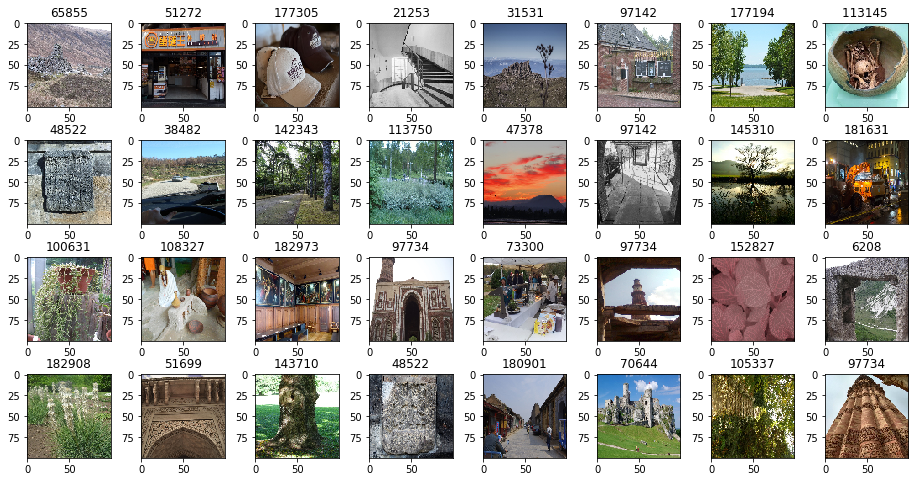

In [7]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

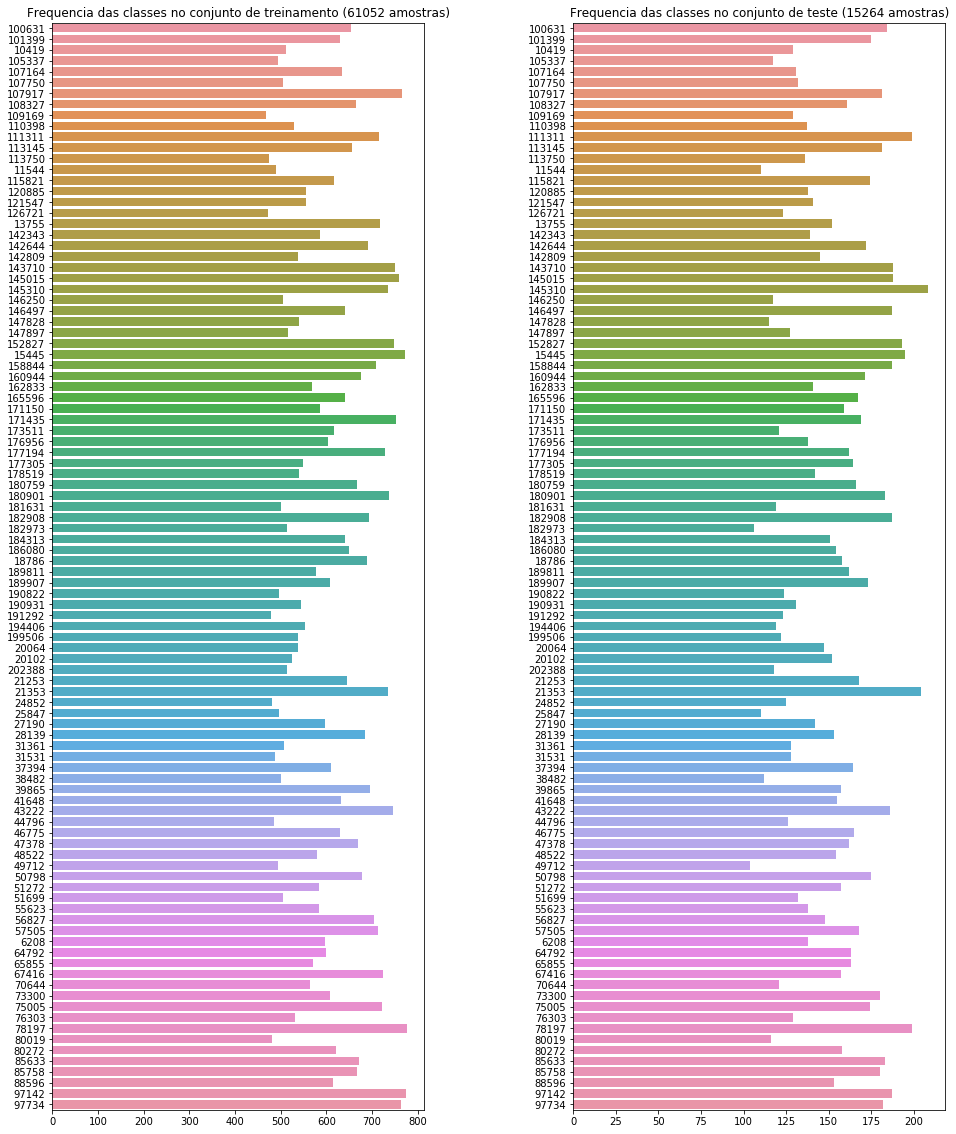

In [62]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [9]:
train_batch_size = 501 # Selecionar um divisor do número de amostras (1 3 5 15 17 51 85 167 255 501 835 2505 2839 8517 14195 42585)
val_batch_size = 379 # Selecionar um divisor do número de amostras (1 2 4 7 14 28 379 758 1516 2653 5306 10612)
test_batch_size = 215 # Selecionar um divisor do número de amostras (1 5 43 83 215 415 3569 17845)

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/test",
                                                  target_size = target_size,
                                                  batch_size = test_batch_size,
                                                  class_mode = "categorical")

Found 48878 images belonging to 100 classes.
Found 12174 images belonging to 100 classes.
Found 15264 images belonging to 100 classes.


# Parâmetros para treinamento e validação

In [10]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 8

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

test_steps = test_generator.samples // test_batch_size

Instructions for updating:
Colocations handled automatically by placer.


# Funções de auxílio

In [11]:
df_resultado = pd.DataFrame(columns=["Rede", 
                                     "train_acc", 
                                     "train_loss", 
                                     "val_acc", 
                                     "val_loss"])
def salvar_resultado(rede,
                     train_acc,
                     train_loss,
                     val_acc,
                     val_loss,
                     df = df_resultado):
  
    df = df.append({"Rede" : rede,
                    "train_acc": train_acc,
                    "train_loss" : train_loss,
                    "val_acc": val_acc,
                    "val_loss": val_loss
                   }, 
                   ignore_index = True)
    return df

In [12]:
def train_model(model, 
                name, 
                train_g = train_generator, 
                validation_g = validation_generator, 
                factor = 1,
                train_epochs = epochs):
  train_g.reset()
  validation_g.reset()
  new_epoch = train_epochs * factor
  patience = new_epoch // 3
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps / factor,
                                 epochs = new_epoch,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                                                      save_best_only=True,
                                                                      verbose=1),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [13]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [14]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [15]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [16]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [17]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [18]:
def evaluate_model(model, name, generator = test_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  val_score = evaluate_generator_model(model, name + '_val', generator, steps)
  train_score = evaluate_generator_model(model, name + '_train', train_generator, train_steps)
  
  print('*** Saving results - Part (5/5)****')
  salvar_resultado(name, train_score[1], train_score[0], val_score[1], val_score[0])

In [19]:
def v(model, name, egenerator = validation_generator, steps = test_batch_size):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  evaluate_generator_model(model, name + '_val', generator, steps)

# Rede *Homemade*

## Definindo a rede

In [63]:
def build_homemade():
  model = Sequential()

  model.add(Conv2D(filters = 10,
                      kernel_size = [3, 3],
                      name = "conv_1",
                      activation = "relu",
                      input_shape = input_shape))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_1"))

  model.add(Conv2D(filters = 20,
                       kernel_size = [3, 3],
                       name = "conv_2",
                       activation = "relu"))
  model.add(Dropout(rate = 0.5, name = "do_1"))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_2"))

  model.add(Flatten())
  model.add(Dense(units = 100,name = "dense_1", activation = 'softmax'))

  model.compile(optimizer = rms,
                    loss = 'categorical_crossentropy',
                    metrics=['accuracy'])

  model.summary()
  return model;

homemade_model = build_homemade()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 49, 49, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 47, 47, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 23, 23, 20)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10580)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1058100   
Total para

## Treinando o modelo

In [64]:
history_homemade = train_model(homemade_model, name =  'homemade', factor = 20)

Epoch 1/160
5/4 [==============================] - 213s 43s/step - loss: 4.8119 - acc: 0.0124 - val_loss: 4.5881 - val_acc: 0.0150

Epoch 00001: val_loss improved from inf to 4.58813, saving model to ./homemade.weights.h5
Epoch 2/160
5/4 [==============================] - 56s 11s/step - loss: 4.6249 - acc: 0.0164 - val_loss: 4.5547 - val_acc: 0.0193

Epoch 00002: val_loss improved from 4.58813 to 4.55470, saving model to ./homemade.weights.h5
Epoch 3/160
5/4 [==============================] - 58s 12s/step - loss: 4.5498 - acc: 0.0232 - val_loss: 4.5296 - val_acc: 0.0309

Epoch 00003: val_loss improved from 4.55470 to 4.52964, saving model to ./homemade.weights.h5
Epoch 4/160
5/4 [==============================] - 58s 12s/step - loss: 4.5003 - acc: 0.0287 - val_loss: 4.5028 - val_acc: 0.0371

Epoch 00004: val_loss improved from 4.52964 to 4.50277, saving model to ./homemade.weights.h5
Epoch 5/160
5/4 [==============================] - 61s 12s/step - loss: 4.4775 - acc: 0.0415 - val_loss

5/4 [==============================] - 60s 12s/step - loss: 3.8340 - acc: 0.1461 - val_loss: 3.9977 - val_acc: 0.1439

Epoch 00038: val_loss improved from 4.01006 to 3.99771, saving model to ./homemade.weights.h5
Epoch 39/160
5/4 [==============================] - 59s 12s/step - loss: 3.8043 - acc: 0.1505 - val_loss: 3.9962 - val_acc: 0.1375

Epoch 00039: val_loss improved from 3.99771 to 3.99624, saving model to ./homemade.weights.h5
Epoch 40/160
5/4 [==============================] - 57s 11s/step - loss: 3.7551 - acc: 0.1612 - val_loss: 3.9832 - val_acc: 0.1474

Epoch 00040: val_loss improved from 3.99624 to 3.98322, saving model to ./homemade.weights.h5
Epoch 41/160
5/4 [==============================] - 61s 12s/step - loss: 3.7927 - acc: 0.1493 - val_loss: 3.9884 - val_acc: 0.1440

Epoch 00041: val_loss did not improve from 3.98322
Epoch 42/160
5/4 [==============================] - 60s 12s/step - loss: 3.7623 - acc: 0.1565 - val_loss: 3.9711 - val_acc: 0.1558

Epoch 00042: val_los

5/4 [==============================] - 60s 12s/step - loss: 3.5444 - acc: 0.1888 - val_loss: 3.7889 - val_acc: 0.1912

Epoch 00077: val_loss did not improve from 3.78590
Epoch 78/160
5/4 [==============================] - 60s 12s/step - loss: 3.5411 - acc: 0.1980 - val_loss: 3.8007 - val_acc: 0.1946

Epoch 00078: val_loss did not improve from 3.78590
Epoch 79/160
5/4 [==============================] - 64s 13s/step - loss: 3.5058 - acc: 0.2105 - val_loss: 3.7863 - val_acc: 0.1930

Epoch 00079: val_loss did not improve from 3.78590
Epoch 80/160
5/4 [==============================] - 62s 12s/step - loss: 3.4935 - acc: 0.2096 - val_loss: 3.7936 - val_acc: 0.1820

Epoch 00080: val_loss did not improve from 3.78590
Epoch 81/160
5/4 [==============================] - 62s 12s/step - loss: 3.4729 - acc: 0.2124 - val_loss: 3.7705 - val_acc: 0.1962

Epoch 00081: val_loss improved from 3.78590 to 3.77050, saving model to ./homemade.weights.h5
Epoch 82/160
5/4 [==============================] - 65s

5/4 [==============================] - 55s 11s/step - loss: 3.3588 - acc: 0.2368 - val_loss: 3.6945 - val_acc: 0.1987

Epoch 00118: val_loss did not improve from 3.66495
Epoch 119/160
5/4 [==============================] - 55s 11s/step - loss: 3.3042 - acc: 0.2491 - val_loss: 3.6899 - val_acc: 0.2088

Epoch 00119: val_loss did not improve from 3.66495
Epoch 120/160
5/4 [==============================] - 55s 11s/step - loss: 3.3130 - acc: 0.2419 - val_loss: 3.6774 - val_acc: 0.2028

Epoch 00120: val_loss did not improve from 3.66495
Epoch 121/160
5/4 [==============================] - 55s 11s/step - loss: 3.3294 - acc: 0.2467 - val_loss: 3.6651 - val_acc: 0.2110

Epoch 00121: val_loss did not improve from 3.66495
Epoch 122/160
5/4 [==============================] - 56s 11s/step - loss: 3.2539 - acc: 0.2527 - val_loss: 3.6609 - val_acc: 0.2160

Epoch 00122: val_loss improved from 3.66495 to 3.66087, saving model to ./homemade.weights.h5
Epoch 123/160
5/4 [==============================] 


Epoch 00159: val_loss did not improve from 3.60137
Epoch 160/160
5/4 [==============================] - 57s 11s/step - loss: 3.1795 - acc: 0.2739 - val_loss: 3.6015 - val_acc: 0.2242

Epoch 00160: val_loss did not improve from 3.60137


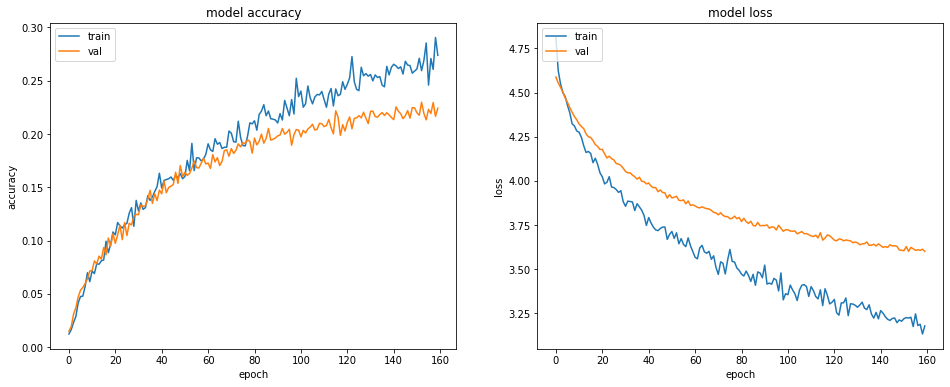

In [65]:
learning_curve_model(history_homemade)

## Avaliando modelo treinado

In [66]:
evaluate_model(homemade_model, 'Homemade')

*** Prediction model - Part (1/5)****


KeyboardInterrupt: 

# ResNet18 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from classification_models.resnet import ResNet18, preprocess_input

def build_resNet18():
  model = ResNet18(input_shape = input_shape,
                   weights = "imagenet",
                   include_top=False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(100,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input, outputs = output)

  model.compile(loss ='categorical_crossentropy', 
                optimizer = rms, 
                metrics=['accuracy'])
  
  model.summary()
  return model

resNet18_feature_model = build_resNet18()

## Fine Tuning

### Definindo a rede

In [0]:
def build_resNet18_tuning():
  model = build_resNet18()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model

resNet18_tunning_model = build_resNet18_tuning()

### Treinando o modelo

In [0]:
history_resNet18_tuning = train_model(resNet18_tunning_model, name =  'ResNet18 - Tuning', factor = 10)

In [0]:
learning_curve_model(history_resNet18_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(resNet18_tunning_model, 'ResNet18 - Tuning')

# VGG16 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

def build_vgg16_feature():
  model = VGG16(input_shape = input_shape,
                      weights = "imagenet",
                      include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                      outputs = output)

  model.compile(loss ='categorical_crossentropy',
                      optimizer = rms,
                      metrics=['accuracy'])

  model.summary()
  return model

vgg16_feature_model = build_vgg16_feature()

## Fine Tuning

### Definindo a rede

In [0]:
def build_vgg16_tuning():
  model = build_vgg16_feature()

  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model
  
vgg16_tunning_model = build_vgg16_tuning();

### Treinando o modelo

In [0]:
history_vgg16_tuning = train_model(vgg16_tunning_model, name =  'VGG16 - Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_vgg16_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(vgg16_tunning_model, 'VGG16 - Tunning')

# InceptionV3 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input


def build_inceptionV3_feature_model():
  model = InceptionV3(input_shape = input_shape,
                                  weights = "imagenet",
                                  include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                            outputs = output)

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_feature_model = build_inceptionV3_feature_model()

## Fine Tuning

### Definindo a rede

In [0]:
def build_inceptionV3_tunning_model():
  model = build_inceptionV3_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_tunning_model = build_inceptionV3_tunning_model()

### Treinando o modelo

In [0]:
history_inceptionv3_tuning = train_model(inceptionv3_tunning_model, name =  'InceptionV3 - Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_inceptionv3_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(inceptionv3_tunning_model, 'InceptionV3 - Tunning')

# MobileNetV2 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

def build_mobileNet_feature_model():
  model = MobileNetV2(input_shape = input_shape,
                                weights = "imagenet",
                                include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                          outputs = output)

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_feature_model = build_mobileNet_feature_model()

## Fine Tuning

### Definindo a rede

In [0]:
def build_mobileNet_tunning_model():
  model = build_mobileNet_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_tunning_model = build_mobileNet_tunning_model()

### Treinando o modelo

In [0]:
history_mobileNet_tunning = train_model(mobileNet_tunning_model, name =  'MobileNet- Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_mobileNet_tunning)

### Avaliando modelo treinado

In [0]:
evaluate_model(mobileNet_tunning_model, 'MobileNet - Tunning')

# Avaliando as redes

## Comparando resultados das redes propostas

In [0]:
df_resultado.sort_values(by=["val_acc"])

## Avaliando no conjunto de teste(a melhor rede)

In [0]:
evaluate_test_model(history_resNet18_tuning, 'MobileNet - Tunning')